In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from PIL import Image
import imageio
import random
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix,classification_report
from keras.optimizers import Adam
import time

#  Data Exploration

In [3]:
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test/'
train_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/'
images_path = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/'
img_size = (128, 128, 3)
num_classes = 10

In [4]:
train_df = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train.csv")
train_df.head(10)

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg
5,8,occluded-specimens,8,L,ccf1b1ccacb8f8b3.jpg
6,11,live-plants,4,US,246c8e9612111a24.jpg
7,12,biocultural-specimens,1,C,b0b337313164a0f0.jpg
8,13,microscope-slides,6,L,b3931bc4cc2b2925.jpg
9,15,illustrations-gray,3,BR,ebf7674e4c2c0e6e.jpg


In [5]:
train_df.shape

(81946, 5)

In [4]:
validation_df = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation.csv")
validation_df.head(10)

,uniqueID,classLabel,classID,source,imageFile
0,7,microscope-slides,6,K,f09a8abe9e9e9ef2.jpg
1,20,illustrations-color,2,BHL,a6c6868387c6af8c.jpg
2,37,ordinary-pressed-specimens,9,YU,6062c68e8c34b292.jpg
3,59,animal-specimens,0,CAS,363617271597dfd9.jpg
4,60,biocultural-specimens,1,Met,4218d8d2f42b05e4.jpg
5,75,illustrations-gray,3,BHL,a08d868b0f0d8484.jpg
6,77,ordinary-pressed-specimens,9,US,6a66c64e1ccdb3f1.jpg
7,88,occluded-specimens,8,MICH,f8e6b0b2b2bafaf2.jpg
8,90,micrographs-transmission-light,5,Tw,c69656e6c6d4c68e.jpg
9,91,live-plants,4,P,e66268a9d0db4e4c.jpg


In [5]:
test_df = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv")
test_df.head(10)

,uniqueID,imageFile
0,1,facd4dcd8e869617.jpg
1,9,78c96bb2b2b62579.jpg
2,10,d292d2c4e0e6ad9d.jpg
3,14,3633494929870713.jpg
4,16,dc94b496c8e2d6c4.jpg
5,24,8e82292b4945cbca.jpg
6,25,65f1c96cf4e064b8.jpg
7,26,e1a4f8f0908de9b9.jpg
8,28,d9594c4ecb435313.jpg
9,34,d44d6996ccc8e26c.jpg


In [34]:
train_df.shape

(81946, 5)

In [35]:
train_df["classLabel"].unique()

array(['occluded-specimens', 'microscope-slides', 'illustrations-color',
       'animal-specimens', 'live-plants', 'biocultural-specimens',
       'illustrations-gray', 'mixed-pressed-specimens',
       'ordinary-pressed-specimens', 'micrographs-transmission-light'],
      dtype=object)

In [36]:
classes = ['occluded-specimens', 'microscope-slides', 'illustrations-color',
       'animal-specimens', 'live-plants', 'biocultural-specimens',
       'illustrations-gray', 'mixed-pressed-specimens',
       'ordinary-pressed-specimens', 'micrographs-transmission-light']

In [37]:
# for images in df
def showImg(idx):
    print("Label: " + train_df["classLabel"][idx])
    example_image_path = train_dir + train_df["imageFile"][idx]
    example_image = np.asarray(cv2.resize(cv2.imread(example_image_path, cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])
    plt.imshow(example_image)

Label: illustrations-color


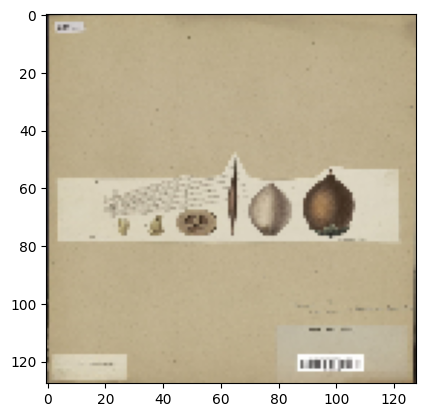

In [38]:
showImg(3)

In [39]:
classID = train_df["classID"].unique()
classID.sort()
classID

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
train_df["source"].unique()

array(['L', 'BHL', 'P', 'AK', 'US', 'C', 'BR', 'MICH', 'E', 'KY', 'F',
       'K', 'NY', 'Tw', 'NMR', 'CHNDM', 'MO', 'UA', 'Met', 'CAS', 'YPM',
       'O', 'GH', 'FMNH', 'MPU', 'YU', 'UMMZ', 'ASU', 'SDNHM', 'NHMD',
       'UHIM', 'RSA', 'MCZ', 'MA', 'MZH', 'TU', 'TTU'], dtype=object)

In [41]:
# Class Distributions 
for i in range(10):
    print("Class ID " + str(i) + " :" + str(train_df["classID"].value_counts()[i]))

Class ID 0 :8194
Class ID 1 :8195
Class ID 2 :8196
Class ID 3 :8196
Class ID 4 :8200
Class ID 5 :8195
Class ID 6 :8192
Class ID 7 :8193
Class ID 8 :8194
Class ID 9 :8191


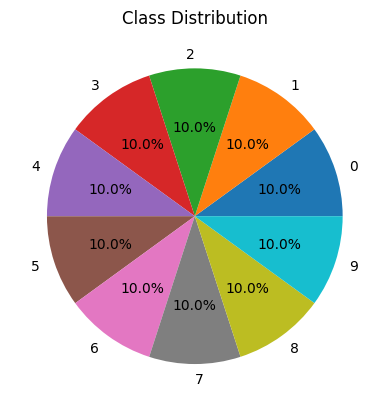

In [42]:
class_dist = np.array([8194, 8195, 8196, 8196, 8200, 8195, 8192, 8193, 8194, 8191])
plt.pie(class_dist, labels=classID, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

In [ ]:
# function that grabs n amount of random files in given directory & displays image/pixel data
def show_img(directory, amt):
    for i in range(amt):
        
        img_name = random.choice(os.listdir(directory))
        img_path = os.path.join(directory, img_name)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.show()
        
        pix = Image.open(img_path)
        width, height = pix.size
        print(img_name + "\nDimensions: " + str(pix.size) + "\n" + "Width: " + str(width) + " Height: " + str(height) + "\n" + "Total pixels:", str(width * height))
        
        if i > amt:
            break

# Data Preproccessing

In [6]:
train_image_directory = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/'
validation_image_directory = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'

classLabel
live-plants                       8200
illustrations-color               8196
illustrations-gray                8196
biocultural-specimens             8195
micrographs-transmission-light    8195
occluded-specimens                8194
animal-specimens                  8194
mixed-pressed-specimens           8193
microscope-slides                 8192
ordinary-pressed-specimens        8191
Name: count, dtype: int64
Found 81946 validated image filenames belonging to 10 classes.
Found 10244 validated image filenames belonging to 10 classes.


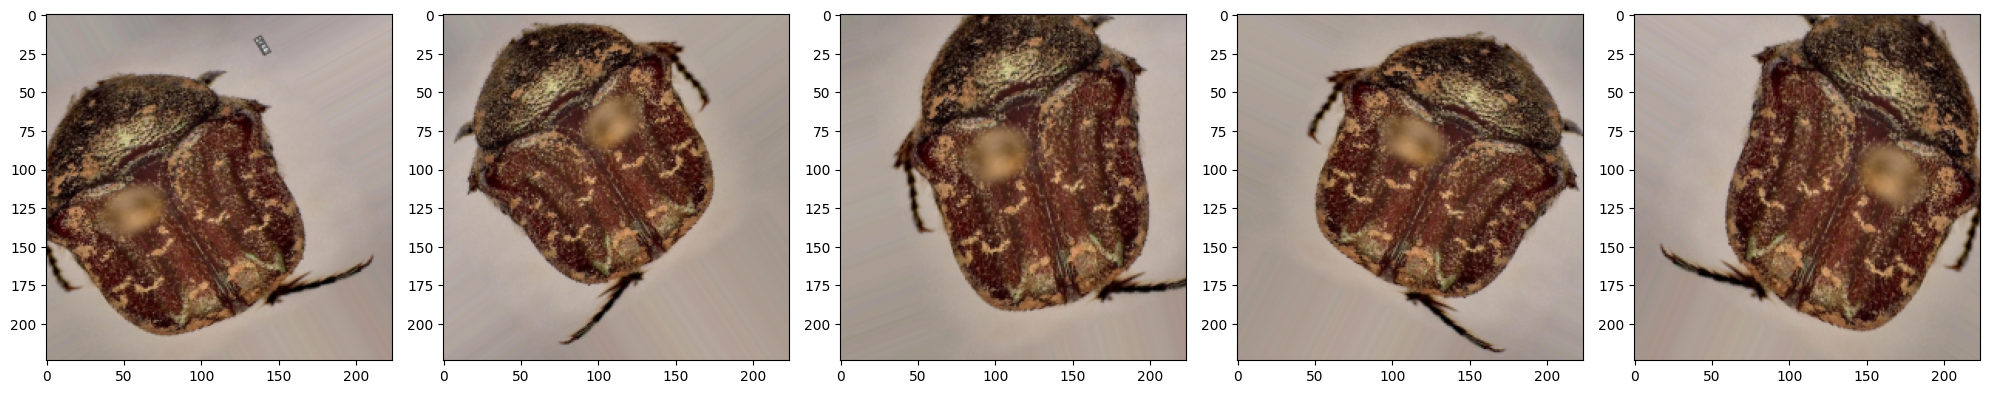

In [7]:
def load_and_preprocess_image(image_data, target_size=(224, 224)):
    image_data = image_data / 255.0 # Rescale to [0, 1]
    layer = Normalization(mean=[0.485, 0.456, 0.406], 
                          variance=[np.square(0.299), 
                                    np.square(0.224), 
                                    np.square(0.225)])
    # tf.image.per_image_standardization(image_data)
    return layer(image_data)

datagen = ImageDataGenerator()
print(train_df['classLabel'].value_counts())

# Data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # rotation_range=40,
    width_shift_range=0.15, # width_shift_range=0.2,
    height_shift_range=0.15, # height_shift_range=0.2,
    shear_range=0.15, # shear_range=0.2,
    zoom_range=0.15, # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    # preprocessing_function=load_and_preprocess_image
)

# Note: No augmentation for validation data, only rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255 # happens in preprocessing func below
    # preprocessing_function=load_and_preprocess_image
)

# Convert dataframe to a format suitable for the model training
def df_to_dataset(dataframe, image_directory, datagen, batch_size=32):
    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical' 
    )
    return dataset

# Create datasets for training and validation
train_dataset = df_to_dataset(train_df, train_image_directory, train_datagen, 32)
validation_dataset = df_to_dataset(validation_df, validation_image_directory, validation_datagen, 32)

# This function will plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_dataset[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Model Training

In [8]:
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D, BatchNormalization 
from keras import layers
from keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.layers as lyrs
from keras.models import load_model

### Simple resnet

In [ ]:
num_classes = 10

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Modyfing the simpler model with additional dense layers/2dAvgPooling

In [11]:
num_classes = 10

model4 = Sequential()
model4.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

model4.compile(optimizer=SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 2s 0us/step


In [9]:
num_classes = 10

model5 = Sequential()
model5.add(ResNet101(include_top=False, pooling='avg', weights='imagenet'))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes, activation='softmax'))

model5.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 1s 0us/step


In [12]:
history4 = model4.fit(train_dataset, epochs=3, validation_data=validation_dataset)

Epoch 1/3
2561/2561 [==============================] - 2430s 942ms/step - loss: 0.2359 - accuracy: 0.9218 - val_loss: 0.1474 - val_accuracy: 0.9488
Epoch 2/3
2561/2561 [==============================] - 1787s 698ms/step - loss: 0.1125 - accuracy: 0.9620 - val_loss: 0.0987 - val_accuracy: 0.9654
Epoch 3/3
2561/2561 [==============================] - 1803s 704ms/step - loss: 0.0878 - accuracy: 0.9698 - val_loss: 0.0752 - val_accuracy: 0.9726


In [22]:
model.save('/kaggle/working/model6.keras')

In [10]:
history5 = model5.fit(train_dataset, epochs=4, validation_data=validation_dataset)

Epoch 1/4
2561/2561 [==============================] - 2049s 788ms/step - loss: 0.2194 - accuracy: 0.9274 - val_loss: 0.1324 - val_accuracy: 0.9521
Epoch 2/4
2561/2561 [==============================] - 1550s 605ms/step - loss: 0.1041 - accuracy: 0.9647 - val_loss: 0.1255 - val_accuracy: 0.9565
Epoch 3/4
2561/2561 [==============================] - 1512s 590ms/step - loss: 0.0790 - accuracy: 0.9728 - val_loss: 0.0889 - val_accuracy: 0.9695
Epoch 4/4
2561/2561 [==============================] - 1490s 582ms/step - loss: 0.0654 - accuracy: 0.9773 - val_loss: 0.0772 - val_accuracy: 0.9735


In [11]:
history5 = model5.fit(train_dataset, epochs=1, validation_data=validation_dataset)

2561/2561 [==============================] - 1481s 578ms/step - loss: 0.0575 - accuracy: 0.9803 - val_loss: 0.1181 - val_accuracy: 0.9610


In [12]:
history5 = model5.fit(train_dataset, epochs=1, validation_data=validation_dataset)

2561/2561 [==============================] - 1512s 590ms/step - loss: 0.0501 - accuracy: 0.9827 - val_loss: 0.1080 - val_accuracy: 0.9640


In [13]:
history5 = model5.fit(train_dataset, epochs=1, validation_data=validation_dataset)

2561/2561 [==============================] - 1505s 588ms/step - loss: 0.0440 - accuracy: 0.9847 - val_loss: 0.0931 - val_accuracy: 0.9687


In [14]:
history5 = model5.fit(train_dataset, epochs=1, validation_data=validation_dataset)

2561/2561 [==============================] - 1495s 584ms/step - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.0780 - val_accuracy: 0.9759


In [ ]:
history5 = model5.fit(train_dataset, epochs=1, validation_data=validation_dataset)

 History 5: 18/2561 [..............................] - ETA: 32:04 - loss: 0.0151 - accuracy: 0.9965

### Predict

In [19]:
test_data = pd.read_csv("/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test.csv")
test_dir = '/kaggle/input/bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_dir,
    x_col="imageFile",
    y_col=None,
    target_size=(224, 224), 
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_preds = model5.predict(test_generator)

test_predictions = test_preds.argmax(axis=-1)

test_data['classID'] = test_predictions
test_data[['uniqueID', 'classID']].to_csv('predictions.csv', index=False)

Found 30690 validated image filenames.
960/960 [==============================] - 248s 258ms/step
